# Road Follower - Train Model(モデルの学習)

In this notebook we will train a neural network to take an input image, and output a set of x, y values corresponding to a target.

(訳) このnotebookは、入力画像を読み込み、ターゲットに対応するx、y値のセットを出力するようにニューラルネットワークを学習します。

We will be using PyTorch deep learning framework to train ResNet18 neural network architecture model for road follower application.

(訳) road followerアプリのためにResNet18 neural networkアーキテクチャーモデルを学習するために、PyTorch deep learningフレームワークを使用します。

In [1]:
! pip3 install tqdm

  Using cached https://files.pythonhosted.org/packages/e1/c1/bc1dba38b48f4ae3c4428aea669c5e27bd5a7642a74c8348451e0bd8ff86/tqdm-4.36.1-py2.py3-none-any.whl


In [2]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import glob
import PIL.Image
import os
import numpy as np
from tqdm import tqdm

### Create Dataset Instance(データセットインスタンスの作成)

Here we create a custom ``torch.utils.data.Dataset`` implementation, which implements the ``__len__`` and ``__getitem__`` functions.  This class
is responsible for loading images and parsing the x, y values from the image filenames.  Because we implement the ``torch.utils.data.Dataset`` class,
we can use all of the torch data utilities :)

(訳) ``__len__`` と ``__getitem__``関数が実装されたカスタマイズされた``torch.utils.data.Dataset`` の実装を生成します。このクラスは、画像をロードするための役割と、画像ファイル名からx、y値の値をパースして取得します。`torch.utils.data.Dataset``を実装する事で、すべてのtorchデータユーティリティを使用する事ができます。

We hard coded some transformations (like color jitter) into our dataset.  We made random horizontal flips optional (in case you want to follow a non-symmetric path, like a road
where we need to 'stay right').  If it doesn't matter whether your robot follows some convention, you could enable flips to augment the dataset.

(訳) いくつかの変換（カラージッターなど）をデータセットにハードコーディングしました。ランダムな水平反転をオプションにしました（「右にとどまる」必要がある道路のように、非対称の経路をたどる場合）。ロボットが何らかの規則に従っているかどうかが重要でない場合は、フリップを有効にしてデータセットを拡張できます

In [3]:
def get_x(path):
    """Gets the x value from the image filename"""
    return (float(int(path[3:6])) - 50.0) / 50.0

def get_y(path):
    """Gets the y value from the image filename"""
    return (float(int(path[7:10])) - 50.0) / 50.0

class XYDataset(torch.utils.data.Dataset):
    
    def __init__(self, directory, random_hflips=False):
        self.directory = directory
        self.random_hflips = random_hflips
        self.image_paths = glob.glob(os.path.join(self.directory, '*.jpg'))
        self.color_jitter = transforms.ColorJitter(0.3, 0.3, 0.3, 0.3)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        
        image = PIL.Image.open(image_path)
        x = float(get_x(os.path.basename(image_path)))
        y = float(get_y(os.path.basename(image_path)))
        
        if float(np.random.rand(1)) > 0.5:
            image = transforms.functional.hflip(image)
            x = -x
        
        image = self.color_jitter(image)
        image = transforms.functional.resize(image, (224, 224))
        image = transforms.functional.to_tensor(image)
        image = image.numpy()[::-1].copy()
        image = torch.from_numpy(image)
        image = transforms.functional.normalize(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
        return image, torch.tensor([x, y]).float()
    
dataset = XYDataset('dataset_xy', random_hflips=False)

### Split dataset into train and test sets(トレーニングとテスト用のデータセットに分ける)
Once we read dataset, we will split data set in train and test sets. In this example we split train and test a 90%-10%. The test set will be used to verify the accuracy of the model we train.

データセットをロードしたら、トレーニング用とテスト用のデータセットに分割します。この例では、トレーニング用が90%, テスト用が10%で分けます。テストセットは、トレーニングするモデルの精度を検証するために使用されます。

In [4]:
test_percent = 0.1
num_test = int(test_percent * len(dataset))
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset) - num_test, num_test])

### Create data loaders to load data in batches(バッチでデータを読み込むためのdata loadersを作成)

We use ``DataLoader`` class to load data in batches, shuffle data and allow using multi-subprocesses. In this example we use batch size of 64. Batch size will be based on memory available with your GPU and it can impact accuracy of the model.

(訳) `` DataLoader``クラスは、並行したサブプロセスを使用して、データのシャッフル、バッチでのデータロードのために使用します。この例では、64のバッチサイズを使用します。バッチサイズは、GPUで使用可能なメモリに基づいており、モデルの精度に影響を与える可能性があります。

In [5]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4
)

### Define Neural Network Model (Neural netwrk modelの定義)

We use ResNet-18 model available on PyTorch TorchVision. 

(訳) PyToch TouchVisionで使用可能なResNet-18モデルを使用します。

In a process called transfer learning, we can repurpose a pre-trained model (trained on millions of images) for a new task that has possibly much less data available.

(訳)*転移学習*と呼ばれる手法で、利用可能なデータがはるかに少ない状態で新しいタスクをおこなうために、事前にトレーニングされたモデル（数百万の画像でトレーニングされた）を再利用する事ができます。

More details on ResNet-18 : https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py

More Details on Transfer Learning: https://www.youtube.com/watch?v=yofjFQddwHE 

(訳) ResNet-18の詳細: https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py

転移学習の詳細: https://www.youtube.com/watch?v=yofjFQddwHE

In [6]:
model = models.resnet18(pretrained=True)

ResNet model has fully connect (fc) final layer with 512 as ``in_features`` and we will be training for regression thus ``out_features`` as 1

(訳) ResNetのモデルは、`in_features``として、512を最終レイヤーに全結合します。そして、``out_features``2(x,y座標)にして回帰のトレーニングをおこないます。

Finally, we transfer our model for execution on the GPU

最後に、GPUで実行するために、モデルを転送します。

In [7]:
model.fc = torch.nn.Linear(512, 2)
device = torch.device('cuda')
model = model.to(device)

### Train Regression:

We train for 70 epochs and save best model if the loss is reduced. 

70エポック学習し、損失が減少した場合は、ベストなモデルを保存します。

In [8]:
NUM_EPOCHS = 70
BEST_MODEL_PATH = 'best_steering_model_xy.pth'
best_loss = 1e9

optimizer = optim.Adam(model.parameters())
epoch_list = []
train_loss_list = []
test_loss_list = []

for epoch in tqdm(range(NUM_EPOCHS)):
    
    model.train()
    train_loss = 0.0
    for images, labels in iter(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = F.mse_loss(outputs, labels)
        train_loss += float(loss)
        loss.backward()
        optimizer.step()
    train_loss /= len(train_loader)
    
    model.eval()
    test_loss = 0.0
    for images, labels in iter(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = F.mse_loss(outputs, labels)
        test_loss += float(loss)
    test_loss /= len(test_loader)
    
    print('train loss %f, test_loss %f' % (train_loss, test_loss))
    epoch_list.append(epoch) 
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    if test_loss < best_loss:
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        best_loss = test_loss

  0%|          | 0/70 [00:00<?, ?it/s]

train loss 1.263444, test_loss 18.291302


  1%|▏         | 1/70 [00:32<36:58, 32.15s/it]

train loss 0.968418, test_loss 0.262598


  4%|▍         | 3/70 [01:07<27:07, 24.29s/it]

train loss 0.216813, test_loss 0.964457


  6%|▌         | 4/70 [01:18<22:28, 20.43s/it]

train loss 0.163334, test_loss 0.354809


  7%|▋         | 5/70 [01:29<19:03, 17.59s/it]

train loss 0.108680, test_loss 1.630302


  9%|▊         | 6/70 [01:40<16:27, 15.43s/it]

train loss 0.083790, test_loss 2.684981
train loss 0.063508, test_loss 0.169249


 11%|█▏        | 8/70 [01:58<12:35, 12.19s/it]

train loss 0.060089, test_loss 0.208757
train loss 0.056216, test_loss 0.159305


 13%|█▎        | 9/70 [02:07<11:32, 11.35s/it]

train loss 0.038791, test_loss 0.066456


 16%|█▌        | 11/70 [02:26<10:01, 10.20s/it]

train loss 0.042158, test_loss 0.072030
train loss 0.037995, test_loss 0.025546


 17%|█▋        | 12/70 [02:35<09:34,  9.90s/it]

train loss 0.040223, test_loss 0.019419


 20%|██        | 14/70 [02:53<08:53,  9.53s/it]

train loss 0.028970, test_loss 0.028435
train loss 0.037437, test_loss 0.013163


 23%|██▎       | 16/70 [03:12<08:24,  9.34s/it]

train loss 0.035558, test_loss 0.037051


 24%|██▍       | 17/70 [03:21<08:11,  9.28s/it]

train loss 0.037923, test_loss 0.037283


 26%|██▌       | 18/70 [03:30<07:58,  9.21s/it]

train loss 0.034203, test_loss 0.025255


 27%|██▋       | 19/70 [03:39<07:45,  9.14s/it]

train loss 0.038991, test_loss 0.026074


 29%|██▊       | 20/70 [03:48<07:35,  9.10s/it]

train loss 0.043179, test_loss 0.023103


 30%|███       | 21/70 [03:57<07:25,  9.09s/it]

train loss 0.031386, test_loss 0.040249


 31%|███▏      | 22/70 [04:06<07:17,  9.12s/it]

train loss 0.051035, test_loss 0.030277


 33%|███▎      | 23/70 [04:15<07:08,  9.12s/it]

train loss 0.035147, test_loss 0.032494


 34%|███▍      | 24/70 [04:24<07:00,  9.14s/it]

train loss 0.027218, test_loss 0.027905


 36%|███▌      | 25/70 [04:34<06:57,  9.28s/it]

train loss 0.045177, test_loss 0.031081


 37%|███▋      | 26/70 [04:43<06:45,  9.22s/it]

train loss 0.035936, test_loss 0.026649


 39%|███▊      | 27/70 [04:52<06:34,  9.17s/it]

train loss 0.030867, test_loss 0.018403


 40%|████      | 28/70 [05:01<06:21,  9.08s/it]

train loss 0.039130, test_loss 0.060535


 41%|████▏     | 29/70 [05:10<06:10,  9.03s/it]

train loss 0.034376, test_loss 0.026210


 43%|████▎     | 30/70 [05:19<06:02,  9.05s/it]

train loss 0.031472, test_loss 0.040371


 44%|████▍     | 31/70 [05:28<05:52,  9.03s/it]

train loss 0.035195, test_loss 0.035087


 46%|████▌     | 32/70 [05:37<05:41,  8.98s/it]

train loss 0.035017, test_loss 0.033516


 47%|████▋     | 33/70 [05:46<05:33,  9.02s/it]

train loss 0.040842, test_loss 0.027822


 49%|████▊     | 34/70 [05:55<05:22,  8.97s/it]

train loss 0.026802, test_loss 0.034690


 50%|█████     | 35/70 [06:03<05:11,  8.91s/it]

train loss 0.031227, test_loss 0.032966


 51%|█████▏    | 36/70 [06:13<05:04,  8.96s/it]

train loss 0.029394, test_loss 0.026589


 53%|█████▎    | 37/70 [06:22<04:56,  8.99s/it]

train loss 0.023291, test_loss 0.023176


 54%|█████▍    | 38/70 [06:31<04:47,  8.99s/it]

train loss 0.028275, test_loss 0.016254


 56%|█████▌    | 39/70 [06:40<04:40,  9.03s/it]

train loss 0.035952, test_loss 0.021916


 57%|█████▋    | 40/70 [06:49<04:29,  8.99s/it]

train loss 0.027332, test_loss 0.031935


 59%|█████▊    | 41/70 [06:57<04:19,  8.95s/it]

train loss 0.027638, test_loss 0.024185


 60%|██████    | 42/70 [07:06<04:09,  8.91s/it]

train loss 0.034612, test_loss 0.033714


 61%|██████▏   | 43/70 [07:15<04:02,  8.99s/it]

train loss 0.037673, test_loss 0.036998


 63%|██████▎   | 44/70 [07:24<03:54,  9.01s/it]

train loss 0.025921, test_loss 0.027219


 64%|██████▍   | 45/70 [07:34<03:46,  9.04s/it]

train loss 0.035055, test_loss 0.033694


 66%|██████▌   | 46/70 [07:43<03:36,  9.02s/it]

train loss 0.039132, test_loss 0.034592


 67%|██████▋   | 47/70 [07:52<03:27,  9.02s/it]

train loss 0.030559, test_loss 0.043854


 69%|██████▊   | 48/70 [08:01<03:18,  9.01s/it]

train loss 0.040055, test_loss 0.058118


 70%|███████   | 49/70 [08:10<03:09,  9.04s/it]

train loss 0.036201, test_loss 0.031701


 71%|███████▏  | 50/70 [08:19<03:01,  9.09s/it]

train loss 0.030731, test_loss 0.034847


 73%|███████▎  | 51/70 [08:28<02:52,  9.10s/it]

train loss 0.032367, test_loss 0.020985


 74%|███████▍  | 52/70 [08:37<02:43,  9.10s/it]

train loss 0.029263, test_loss 0.031469


 76%|███████▌  | 53/70 [08:46<02:34,  9.11s/it]

train loss 0.028696, test_loss 0.040443


 77%|███████▋  | 54/70 [08:55<02:25,  9.11s/it]

train loss 0.030074, test_loss 0.020960


 79%|███████▊  | 55/70 [09:04<02:16,  9.07s/it]

train loss 0.028857, test_loss 0.033286


 80%|████████  | 56/70 [09:13<02:05,  8.98s/it]

train loss 0.025363, test_loss 0.035735


 81%|████████▏ | 57/70 [09:22<01:57,  9.03s/it]

train loss 0.033249, test_loss 0.028658


 83%|████████▎ | 58/70 [09:32<01:49,  9.10s/it]

train loss 0.025847, test_loss 0.032108


 84%|████████▍ | 59/70 [09:41<01:40,  9.10s/it]

train loss 0.023660, test_loss 0.047173


 86%|████████▌ | 60/70 [09:50<01:30,  9.09s/it]

train loss 0.027214, test_loss 0.039433


 87%|████████▋ | 61/70 [09:59<01:21,  9.09s/it]

train loss 0.032718, test_loss 0.040905


 89%|████████▊ | 62/70 [10:08<01:12,  9.08s/it]

train loss 0.041829, test_loss 0.058767


 90%|█████████ | 63/70 [10:17<01:03,  9.09s/it]

train loss 0.035090, test_loss 0.022790


 91%|█████████▏| 64/70 [10:26<00:54,  9.05s/it]

train loss 0.040146, test_loss 0.025614


 93%|█████████▎| 65/70 [10:35<00:45,  9.03s/it]

train loss 0.037233, test_loss 0.063094


 94%|█████████▍| 66/70 [10:44<00:35,  8.99s/it]

train loss 0.032645, test_loss 0.032771


 96%|█████████▌| 67/70 [10:53<00:27,  9.02s/it]

train loss 0.024957, test_loss 0.030568


 97%|█████████▋| 68/70 [11:02<00:18,  9.04s/it]

train loss 0.022731, test_loss 0.045407


 99%|█████████▊| 69/70 [11:11<00:09,  9.08s/it]

train loss 0.026247, test_loss 0.032394


100%|██████████| 70/70 [11:20<00:00,  9.73s/it]

train loss 0.029018, test_loss 0.037255


損失(Loss)から学習が正常に動作しているか確認

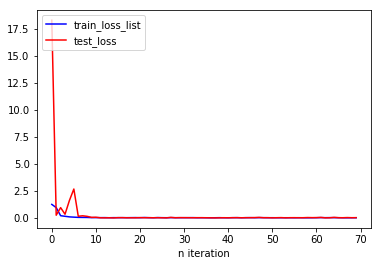

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(epoch_list, train_loss_list, '-b', label='train_loss_list')
plt.plot(epoch_list, test_loss_list, '-r', label='test_loss')

plt.xlabel("n iteration")
plt.legend(loc='upper left')

# show
plt.show()

Once the model is trained, it will generate ``best_steering_model_xy.pth`` file which you can use for inferencing in the live demo notebook.

(訳)学習が完了すると、Live demo notebookで推論に使う``best_steering_model_xy.pth``が生成されます。

If you trained on a different machine other than JetBot, you'll need to upload this to the JetBot to the ``road_following`` example folder.
